In [1]:
import bs4 as bs
import datetime as dt 
import os
import matplotlib.pyplot as plt 
from matplotlib import style
import numpy as np 
import pandas as pd 
import pandas_datareader.data as web
import pickle
import requests
import sys

In [2]:
print(sys.stdin)

# Set style
style.use('ggplot')

<_io.TextIOWrapper name='<stdin>' mode='r' encoding='cp1252'>


In [3]:
def calculate_returns(df):
    main_df = df.copy()
    main_df.set_index('date', inplace = True)


    returns_daily = main_df.pct_change()
    returns_daily.to_csv('sp500_daily_returns.csv')
    returns_annual = returns_daily.mean() * 250

    #print(returns_daily.head())
    #print(returns_annual)

    return returns_daily, returns_annual

def calculate_covariance(df):

    ret_daily, ret_annual = calculate_returns(df)

    covariance_daily = ret_daily.cov()
    covariance_daily.to_csv('sp500_daily_covariance.csv')
    covariance_annual = covariance_daily * 250
    covariance_annual.to_csv('sp500_annual_covariance.csv')

    #print(covariance_daily.head())
    #print(covariance_annual)

    return covariance_daily, covariance_annual

In [4]:
stocks = pd.read_csv('df_simplified_port.csv')
stocks['Date'] = pd.to_datetime(stocks['Date'] )
stocks.rename(columns = {'Date': 'date'}, inplace = True)

In [5]:
stocks.head()

,date,SP500,JPM,JPM_Vol,BAC,BAC_Vol,WFC,WFC_Vol,C,C_Vol,BK,BK_Vol
0,1984-01-03,164.039993,2.116663,385650,1.163508,194400,0.391078,494400,8.559441,92048,1.025567,35094
1,1984-01-04,166.779999,2.206861,292500,1.174281,139200,0.391078,614400,8.790153,296145,1.037492,266039
2,1984-01-05,168.809998,2.279019,344250,1.179669,687200,0.397026,1627200,8.951651,724337,1.053393,344152
3,1984-01-06,169.279999,2.254966,194400,1.195828,1779200,0.394052,885600,9.159295,347470,1.065318,243397
4,1984-01-09,168.899994,2.260979,216450,1.206602,1110400,0.391078,1219200,9.090079,1576867,1.069293,54340


In [6]:
stocks.tail()

,date,SP500,JPM,JPM_Vol,BAC,BAC_Vol,WFC,WFC_Vol,C,C_Vol,BK,BK_Vol
10025,2023-10-11,4376.950195,146.149994,8698200,27.020000,38508200,39.689999,14835900,41.529999,12763900,42.150002,2979300
10026,2023-10-12,4349.609863,145.809998,10484400,26.900000,44249800,39.740002,14878100,41.529999,18112500,41.250000,6274700
10027,2023-10-13,4327.779785,148.000000,29427000,26.760000,55089700,40.959999,28077900,41.430000,32082900,41.180000,3921000
10028,2023-10-16,4373.629883,147.850006,12663500,26.990000,56817500,41.650002,18419000,40.950001,25044200,41.840000,4289800
10029,2023-10-17,4373.200195,147.529999,11479500,27.620001,95318500,41.980000,16981600,41.200001,20254900,43.439999,17157700


In [7]:
stocks = stocks.loc[(stocks['date'] >= pd.to_datetime('1984-01-03')) & (stocks['date'] < pd.to_datetime('2020-01-01')),['date', 'JPM', 'BAC', 'WFC', 'C', 'BK']]
# stocks.set_index('date', inplace= True)

In [8]:
stocks.head()

,date,JPM,BAC,WFC,C,BK
0,1984-01-03,2.116663,1.163508,0.391078,8.559441,1.025567
1,1984-01-04,2.206861,1.174281,0.391078,8.790153,1.037492
2,1984-01-05,2.279019,1.179669,0.397026,8.951651,1.053393
3,1984-01-06,2.254966,1.195828,0.394052,9.159295,1.065318
4,1984-01-09,2.260979,1.206602,0.391078,9.090079,1.069293


In [9]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9075 entries, 0 to 9074
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    9075 non-null   datetime64[ns]
 1   JPM     9075 non-null   float64       
 2   BAC     9075 non-null   float64       
 3   WFC     9075 non-null   float64       
 4   C       9075 non-null   float64       
 5   BK      9075 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 496.3 KB


               2601062
Returns       0.175620
Volatility    0.300987
Sharpe Ratio  0.583481
JPM Weight    0.195938
BAC Weight    0.002748
WFC Weight    0.383204
C Weight      0.028829
BK Weight     0.389280
                568889
Returns       0.181309
Volatility    0.305391
Sharpe Ratio  0.593695
JPM Weight    0.237566
BAC Weight    0.001658
WFC Weight    0.549690
C Weight      0.000879
BK Weight     0.210207


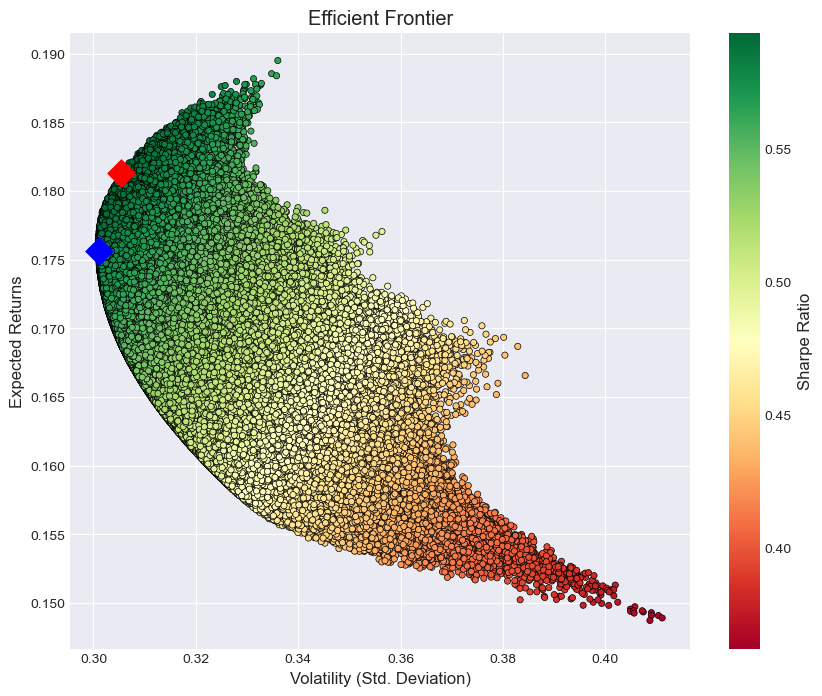

In [10]:
# Create empty lists to store returns, volatility and weights for simulated portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

# Extract returns and covariances from calculate_returns() and calculate_covariance()
ret_daily, ret_annual = calculate_returns(stocks)
cov_daily, cov_annual = calculate_covariance(stocks)

# Set number of assets and number of simulated portfolios
tickers_selected = stocks.columns[1:]
num_assets = len(tickers_selected)
num_portfolios = 5000000


# Populate the empty lists with each portfolio returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, ret_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# Create a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# Accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(tickers_selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# Enhance dataframe
df = pd.DataFrame(portfolio)
df.to_csv('sp500_portfolio.csv')

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in tickers_selected]

# reorder dataframe columns
df = df[column_order]

# Find the optimal Sharpe Ratio and the lowest volatility portfolio
lowest_volatility = df['Volatility'].min()
highest_sharpe_ratio = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == highest_sharpe_ratio]
min_variance_port = df.loc[df['Volatility'] == lowest_volatility]

# print the details of the 2 efficient portfolios
MinVarPort = min_variance_port.T
SharpePort = sharpe_portfolio.T
print(MinVarPort)
print(SharpePort)
MinVarPort.to_csv('sp500_min_variance.csv')
SharpePort.to_csv('sp500_sharpe_ratio.csv')


# Plot the efficient frontier with a scatter plot
plt.style.use('seaborn-dark')
df.plot.scatter(x ='Volatility', y ='Returns', c = 'Sharpe Ratio', cmap = 'RdYlGn', edgecolors = 'black', figsize=(10, 8), grid=True)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [11]:
df

,Returns,Volatility,Sharpe Ratio,JPM Weight,BAC Weight,WFC Weight,C Weight,BK Weight
0,0.167778,0.311958,0.537823,0.204563,0.136346,0.166280,0.205130,0.287681
1,0.173740,0.320806,0.541574,0.298467,0.308867,0.229172,0.087108,0.076386
2,0.163940,0.327650,0.500351,0.232081,0.197303,0.063846,0.319634,0.187136
3,0.170694,0.309444,0.551616,0.055536,0.193857,0.307791,0.146395,0.296420
4,0.175283,0.327254,0.535619,0.082533,0.355323,0.414657,0.128104,0.019384
...,...,...,...,...,...,...,...,...
4999995,0.168861,0.317261,0.532247,0.016335,0.348734,0.212851,0.112441,0.309639
4999996,0.173169,0.329885,0.524935,0.359062,0.367863,0.165745,0.090903,0.016426
4999997,0.161802,0.321814,0.502780,0.027756,0.054311,0.154699,0.369559,0.393674
4999998,0.169069,0.310266,0.544918,0.089420,0.198684,0.237276,0.159490,0.315130


In [46]:
SharpePort[3:]

,568889
JPM Weight,0.237566
BAC Weight,0.001658
WFC Weight,0.549690
C Weight,0.000879
BK Weight,0.210207


In [47]:
port_weights = SharpePort[3:].to_numpy().flatten()
port_weights

array([0.23756602, 0.00165815, 0.54968979, 0.00087891, 0.21020713])

In [48]:
port = pd.read_csv('df_simplified_port.csv')
port['Date'] = pd.to_datetime(port['Date'] )
port.rename(columns = {'Date': 'date'}, inplace = True)
port = port.loc[port['date'] >= pd.to_datetime('2020-01-01'),['date', 'JPM', 'BAC', 'WFC', 'C', 'BK']]
returns_df = port.iloc[:,1:].pct_change().copy()
returns_df.columns = [col + '_ret' for col in returns_df.columns]
returns_df

,JPM_ret,BAC_ret,WFC_ret,C_ret,BK_ret
9075,NaN,NaN,NaN,NaN,NaN
9076,-0.013196,-0.020763,-0.006139,-0.018836,-0.012765
9077,-0.000795,-0.001433,-0.005990,-0.003137,0.009350
9078,-0.017000,-0.006600,-0.008286,-0.008685,0.010051
9079,0.007801,0.010110,0.003038,0.007618,0.001171
...,...,...,...,...,...
10025,0.003433,0.000370,-0.003265,0.002172,-0.003546
10026,-0.002326,-0.004441,0.001260,0.000000,-0.021352
10027,0.015020,-0.005204,0.030699,-0.002408,-0.001697
10028,-0.001013,0.008595,0.016846,-0.011586,0.016027


In [49]:
df_combined = pd.merge(port, returns_df, left_index = True, right_index = True)
df_combined['port_ret'] = df_combined.iloc[:, 6:].dot(port_weights.T)
df_combined.set_index('date', inplace = True)

df_combined

,JPM,BAC,WFC,C,BK,JPM_ret,BAC_ret,WFC_ret,C_ret,BK_ret,port_ret
date,,,,,,,,,,,
2020-01-02,125.020386,32.531406,48.727348,70.525871,45.345711,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,123.370583,31.855946,48.428188,69.197479,44.766861,-0.013196,-0.020763,-0.006139,-0.018836,-0.012765,-0.009244
2020-01-06,123.272476,31.810310,48.138084,68.980408,45.185417,-0.000795,-0.001433,-0.005990,-0.003137,0.009350,-0.001522
2020-01-07,121.176796,31.600376,47.739208,68.381340,45.639580,-0.017000,-0.006600,-0.008286,-0.008685,0.010051,-0.006499
2020-01-08,122.122078,31.919844,47.884251,68.902290,45.693016,0.007801,0.010110,0.003038,0.007618,0.001171,0.003793
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-11,146.149994,27.020000,39.689999,41.529999,42.150002,0.003433,0.000370,-0.003265,0.002172,-0.003546,-0.001722
2023-10-12,145.809998,26.900000,39.740002,41.529999,41.250000,-0.002326,-0.004441,0.001260,0.000000,-0.021352,-0.004356
2023-10-13,148.000000,26.760000,40.959999,41.430000,41.180000,0.015020,-0.005204,0.030699,-0.002408,-0.001697,0.020076


In [50]:
df_combined['port_volume'] = (df_combined['port_ret'] + 1).cumprod() * 100

In [51]:
df_combined

,JPM,BAC,WFC,C,BK,JPM_ret,BAC_ret,WFC_ret,C_ret,BK_ret,port_ret,port_volume
date,,,,,,,,,,,,
2020-01-02,125.020386,32.531406,48.727348,70.525871,45.345711,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,123.370583,31.855946,48.428188,69.197479,44.766861,-0.013196,-0.020763,-0.006139,-0.018836,-0.012765,-0.009244,99.075588
2020-01-06,123.272476,31.810310,48.138084,68.980408,45.185417,-0.000795,-0.001433,-0.005990,-0.003137,0.009350,-0.001522,98.924841
2020-01-07,121.176796,31.600376,47.739208,68.381340,45.639580,-0.017000,-0.006600,-0.008286,-0.008685,0.010051,-0.006499,98.281903
2020-01-08,122.122078,31.919844,47.884251,68.902290,45.693016,0.007801,0.010110,0.003038,0.007618,0.001171,0.003793,98.654674
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-11,146.149994,27.020000,39.689999,41.529999,42.150002,0.003433,0.000370,-0.003265,0.002172,-0.003546,-0.001722,94.511325
2023-10-12,145.809998,26.900000,39.740002,41.529999,41.250000,-0.002326,-0.004441,0.001260,0.000000,-0.021352,-0.004356,94.099641
2023-10-13,148.000000,26.760000,40.959999,41.430000,41.180000,0.015020,-0.005204,0.030699,-0.002408,-0.001697,0.020076,95.988774


In [52]:
df_combined.head(10)

,JPM,BAC,WFC,C,BK,JPM_ret,BAC_ret,WFC_ret,C_ret,BK_ret,port_ret,port_volume
date,,,,,,,,,,,,
2020-01-02,125.020386,32.531406,48.727348,70.525871,45.345711,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,123.370583,31.855946,48.428188,69.197479,44.766861,-0.013196,-0.020763,-0.006139,-0.018836,-0.012765,-0.009244,99.075588
2020-01-06,123.272476,31.810310,48.138084,68.980408,45.185417,-0.000795,-0.001433,-0.005990,-0.003137,0.009350,-0.001522,98.924841
2020-01-07,121.176796,31.600376,47.739208,68.381340,45.639580,-0.017000,-0.006600,-0.008286,-0.008685,0.010051,-0.006499,98.281903
2020-01-08,122.122078,31.919844,47.884251,68.902290,45.693016,0.007801,0.010110,0.003038,0.007618,0.001171,0.003793,98.654674
2020-01-09,122.567947,31.974606,47.802670,69.527405,45.844398,0.003651,0.001716,-0.001704,0.009072,0.003313,0.000638,98.717624
2020-01-10,121.346207,31.709900,47.594151,68.806763,45.007309,-0.009968,-0.008279,-0.004362,-0.010365,-0.018259,-0.008627,97.865997
2020-01-13,122.353912,32.001999,47.240608,70.022285,45.310089,0.008304,0.009212,-0.007428,0.017666,0.006727,-0.000665,97.800870
2020-01-14,123.780800,32.239311,44.693180,71.116257,45.425850,0.011662,0.007416,-0.053925,0.015623,0.002555,-0.026308,95.227905


<AxesSubplot:xlabel='date'>

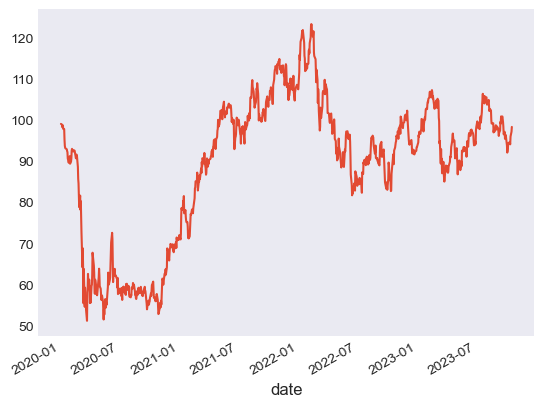

In [53]:
df_combined.port_volume.plot()

In [54]:
100*(1+-0.009244)

99.0756

In [56]:
99.0756*(1+-0.001522)

98.9248069368

In [57]:
98.9248069368*(1+-0.006499)

98.28189461651773

In [58]:
98.28189461651773*(1+0.003793)

98.65467784279818

In [61]:
df_combined.to_csv('df_combined.csv')